In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import cavsim
from cavsim import Measure
from cavsim.connectors import BaseConnector, Connector
from cavsim.channels import ImportChannel, ExportChannel
from cavsim.components import BaseComponent, Component
from cavsim.solvers import BaseSolver, SimpleSolver
from cavsim.fluids import Fluid

In [3]:
from cavsim.pipes.pipe import Pipe
from cavsim.boundaries.left_boundary_pressure import LeftBoundaryPressure
from cavsim.boundaries.left_boundary_velocity import LeftBoundaryVelocity
from cavsim.boundaries.right_boundary_pressure import RightBoundaryPressure
from cavsim.boundaries.right_boundary_velocity import RightBoundaryVelocity

In [4]:
fluid = Fluid(1000, 1e-3, 2.08e9, 2.3e-3)

In [5]:
pipe = Pipe(0.065, 7.0, 0.002, 2e11, 1e-7, 10)

In [6]:
lb = LeftBoundaryPressure(101325)
pipe.connect(lb)

In [7]:
def pump(time):
    return -0.35 * np.minimum(np.sin(2.5 * time * 2.0 * np.pi), 0.0)

In [8]:
def step(time):
    return 0.35 * (time > 0.25)

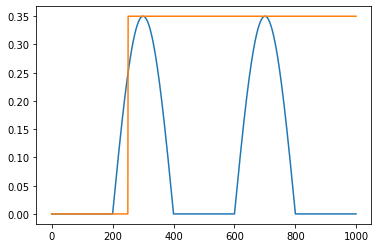

In [9]:
plt.plot(pump(np.arange(1000)/1000))
plt.plot(step(np.arange(1000)/1000))
plt.show()

In [10]:
rb = RightBoundaryVelocity(pump)
pipe.connect(rb)

In [11]:
plogs = []
vlogs = []
flogs = []
rblogs = []
relogs = []
def logging():
    plogs.append(pipe.field_wide_slice('pressure', 0) + 0.0)
    vlogs.append(pipe.field_wide_slice('velocity', 0) + 0.0)
    flogs.append(pipe.field_wide_slice('friction', 0) + 0.0)
    rblogs.append(rb._velocity[0,1])
    relogs.append(pipe.field_wide_slice('reynolds', 0) + 0.0)

In [12]:
solver = SimpleSolver()
solver.fluid = fluid
solver.seeds = pipe
solver._callback = logging

In [13]:
solver.solve(1e20, 1.0, 3)

 0:00:00 [                              |  2.09%]  0:00:08  Currently at time   0.021 of   1.000

/home/jovyan/jupyter/cavsim/base/solvers/simple_solver.py:46: UserWarning: Smaller timestep required by component! (0.0005103895150650787 < 1e+20 by <cavsim.pipes.pipe.Pipe object at 0x7f3c7f0b3208>)
  warn('Smaller timestep required by component! ({} < {} by {})'.format(component_time, delta_t, component))


 0:00:09 [==============================|100.00%]  0:00:00  Currently at time   1.000 of   1.000

In [14]:
pfield = np.stack(plogs)
vfield = np.stack(vlogs)
ffield = np.stack(flogs)
rbfield = np.stack(rblogs)
refield = np.stack(relogs)

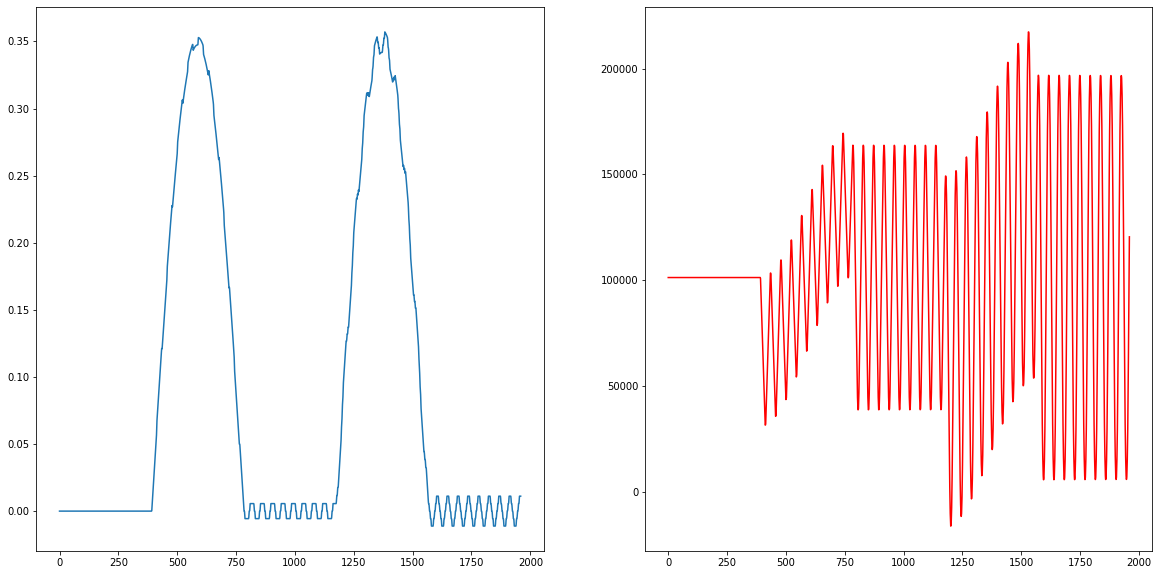

In [15]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(vfield[:,-2])
plt.subplot(1, 2, 2)
plt.plot(pfield[:,-2], color='red')
plt.show()

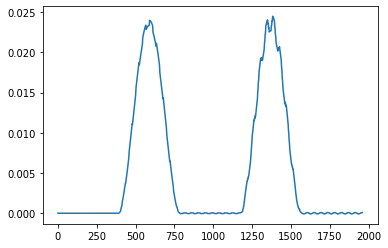

In [16]:
plt.plot(ffield[:,-2])
plt.show()

In [17]:
print(pipe._delta_t)
print(pipe._delta_x)
print(pipe.norm_speed_of_sound)
print(pipe.fluid.norm_density)

0.0005103895150650787
0.6363636363636364
1246.819571288597
1000


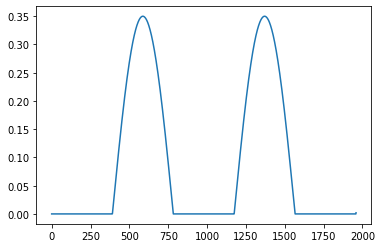

0.0019981572857226105


In [18]:
plt.plot(rbfield)
plt.show()
print(rbfield[-1])

In [19]:
print(vfield[:,-2].shape)

(1960,)


In [20]:
pfe = np.load('pressure_fe.npy')
vfe = np.load('velocity_fe.npy')

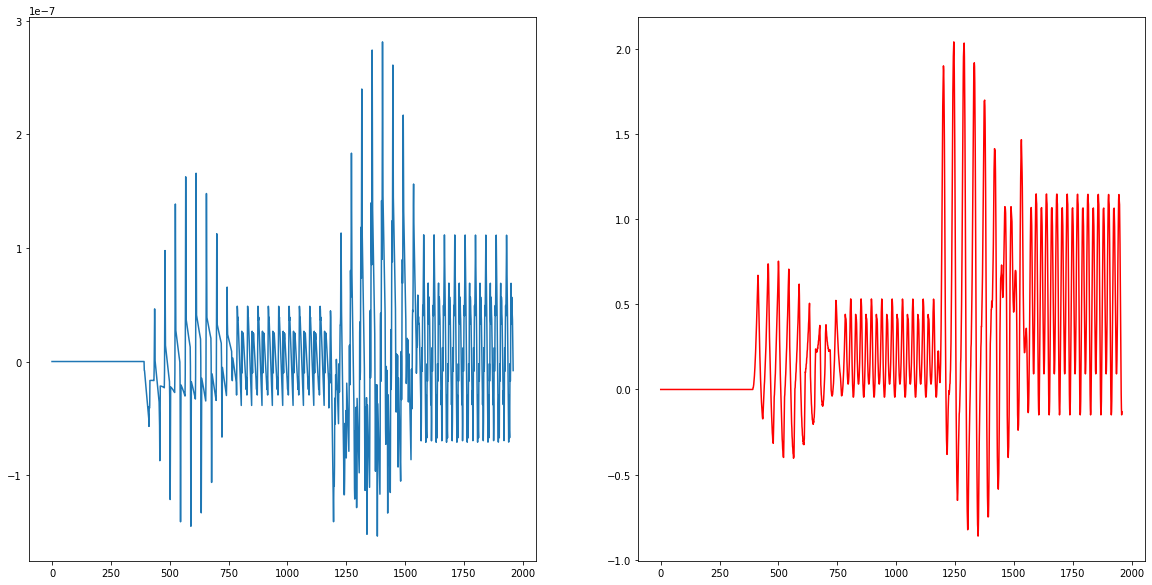

In [21]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(vfield[:,-2] - vfe[:])
#plt.plot(vfe)
plt.subplot(1, 2, 2)
plt.plot(pfield[:,-2] - pfe[:], color='red')
#plt.plot(pfe)
plt.show()

In [22]:
print(pipe.field('velocity').shape)
print(np.load('last_velocity_fe.npy').shape)

(3, 12)
(12,)


In [23]:
rb.prepare_next_timestep(rb._delta_t, 5.000286114406798)
print(pipe.right.value(Measure.velocityMinusCurrent))
pipe.field('velocity')[0,:] = np.load('last_velocity_fe.npy')[:]
pipe.field('pressure')[0,:] = np.load('last_pressure_fe.npy')[:]
pipe.finalize_current_timestep()

-0.0015729908119852698


In [24]:
print(pipe.field('pressure')[0,:].astype(int))

[101325 102385 105917 109449 110996 111554 115053 118551 120544 120544
 120544 118051]


In [25]:
for _ in pipe.field('reynolds')[0,:].tolist(): print(_)

4961.661760994232
4910.119950734814
4729.436324407907
4548.330369944351
4263.627164114747
3875.8728416260114
3334.6247874966275
2792.9158206039665
2172.5827379489724
1448.4835704359014
724.1637146038858
102.24522496535451


In [26]:
for _ in pipe.field('friction_steady')[0,:].tolist(): print(1000*_)

1.6797830236268325
1.6500188611620095
1.547483262240913
1.447544372782323
1.2962448996098566
1.1017603829425766
0.8531385772032554
0.6318402075294954
0.41379755082911934
0.16877785219723263
0.08437982931955204
0.011913680761689378


In [27]:
for _ in pipe.field('velocity')[0,:]: print(_)

0.07633325786144972
0.07554026842287324
0.07276039820247467
0.06997404007115257
0.06559395908007991
0.05962851969334082
0.05130158119606159
0.042967579851971714
0.03342404096691985
0.022284156709051987
0.011140877281785538
0.0015729908119852698


In [28]:
#rb.prepare_next_timestep(rb._delta_t, 1.0003634565925612)
pipe.right.value(Measure.velocityMinusCurrent)

-0.0015729908119852698

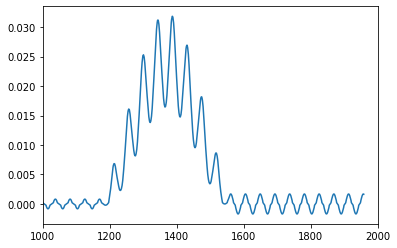

In [29]:
plt.plot(ffield[:,1])
plt.xlim(1000,2000)
plt.show()